# CMU 10-405/10-605 auto-graded notebook

Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel → Restart) and then **run all cells** (in the menubar, select Cell → Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

In [0]:
#CMU 10405/10605 Machine Learning with Large Datasets

# Homework 2 - Part 2:  PCA

In [0]:
# Who did you collaborate with on this assignment? 
# if no one, collaborators should contain an empty string,
# else list your collaborators below

collaborators = [""]
# YOUR CODE HERE
# raise NotImplementedError()

In [0]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")

In [0]:
from nose.tools import assert_equal, assert_true

In [0]:
# YOU CAN MOST LIKELY IGNORE THIS CELL. This is only of use for running this notebook locally.

# THIS CELL DOES NOT NEED TO BE RUN ON DATABRICKS. 
# Note that Databricks already creates a SparkContext for you, so this cell can be skipped.
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext
sc = pyspark.SparkContext(appName="hw")
sqlContext = SQLContext(sc)

print("spark context started")

# Principle Component Analysis

In this part we will dive into exploratory analysis of neuroscience data, specifically using principal component analysis (PCA) and feature-based aggregation. We will use a dataset of light-sheet imaging recorded by the [Ahrens Lab](http://www.janelia.org/lab/ahrens-lab) at Janelia Research Campus.

Our dataset is generated by studying the movement of a larval [zebrafish](http://en.wikipedia.org/wiki/Zebrafish), an animal that is especially useful in neuroscience because it is transparent, making it possible to record activity over its entire brain using a technique called [light-sheet microscopy](http://en.wikipedia.org/wiki/Light_sheet_fluorescence_microscopy).   Specifically, we'll work with time-varying images containing patterns of the zebrafish's neural activity as it is presented with a moving visual pattern.   Different stimuli induce different patterns across the brain, and we can use exploratory analyses to identify these patterns.  Read ["Mapping brain activity at scale with cluster computing"](https://www.janelia.org/sites/default/files/Library/nmeth.3041.pdf) for more information about these kinds of analyses.

During this lab you will learn about PCA, and then compare and contrast different exploratory analyses of the same data set to identify which neural patterns they best highlight.

## This section will cover:

*  *Part 1:* Work through the steps of PCA on a sample dataset
 * *Visualization 1:* Two-dimensional Gaussians

*  *Part 2:* Write a PCA function and evaluate PCA on sample datasets
 * *Visualization 2:* PCA projection
 * *Visualization 3:* Three-dimensional data
 * *Visualization 4:* 2D representation of 3D data

*  *Part 3:* Parse, inspect, and preprocess neuroscience data then perform PCA
 * *Visualization 5:* Pixel intensity
 * *Visualization 6:* Normalized data
 * *Visualization 7:* Top two components as images
 * *Visualization 8:* Top two components as one image

*  *Part 4:* Perform feature-based aggregation followed by PCA
 * *Visualization 9:* Top two components by time
 * *Visualization 10:* Top two components by direction

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [PySpark's DataFrame API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.DataFrame)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

## Part 1: Work through the steps of PCA on a sample dataset

### Visualization 1: Two-dimensional Gaussians

Principal Component Analysis, or PCA, is a strategy for dimensionality reduction. To better understand PCA, we'll work with synthetic data generated by sampling from the [two-dimensional Gaussian distribution](http://en.wikipedia.org/wiki/Multivariate_normal_distribution).  This distribution takes as input the mean and variance of each dimension, as well as the covariance between the two dimensions.

In our visualizations below, we will specify the mean of each dimension to be 50 and the variance along each dimension to be 1.  We will explore two different values for the covariance: 0 and 0.9. When the covariance is zero, the two dimensions are uncorrelated, and hence the data looks spherical.  In contrast, when the covariance is 0.9, the two dimensions are strongly (positively) correlated and thus the data is non-spherical.  As we'll see in Parts 1 and 2, the non-spherical data is amenable to dimensionality reduction via PCA, while the spherical data is not.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create_2D_gaussian(mn, variance, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[variance, cov], [cov, variance]]), n)

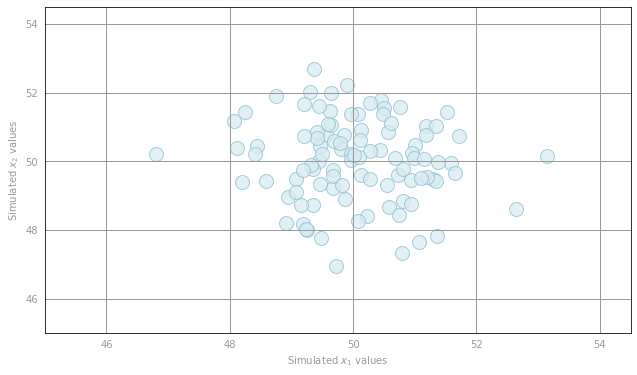

In [0]:
data_random = create_2D_gaussian(mn=50, variance=1, cov=0, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
display(fig)

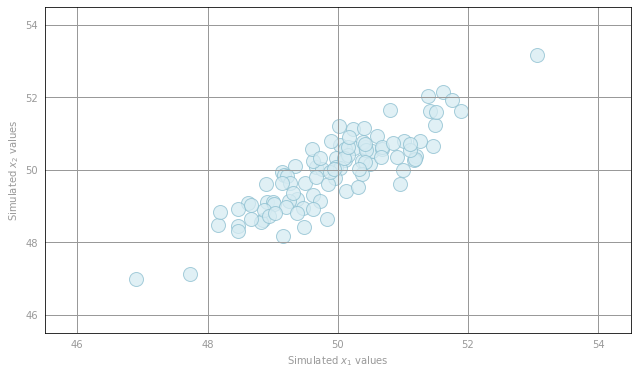

In [0]:
data_correlated = create_2D_gaussian(mn=50, variance=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
display(fig)

### (1a) Interpreting PCA

PCA can be interpreted as identifying the "directions" along which the data vary the most. In the first step of PCA, we must first center our data.  Working with our correlated dataset, first compute the mean of each feature (column) in the dataset.  Then for each observation, modify the features by subtracting their corresponding mean, to create a zero mean dataset.

> Note:
> * `correlated_data` is an RDD of NumPy arrays.
> * This allows us to perform certain operations more succinctly.
> * For example, we can sum the columns of our dataset using `correlated_data.sum()`.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to interprete PCA
correlated_data = sc.parallelize(data_correlated)

# # Interpreting PCA, first compute the mean and subtract it from the original feature
mean_correlated = correlated_data.sum() / correlated_data.count()
correlated_data_zero_mean = correlated_data.map(lambda x:x-mean_correlated)


# YOUR CODE HERE
# raise NotImplementedError()

print(mean_correlated)
print(correlated_data.take(1))
print(correlated_data_zero_mean.take(1))

[49.95739037 49.97180477]
[array([49.6717712 , 50.07531969])]
[array([-0.28561917, 0.10351492])]

In [0]:
# TEST Interpreting PCA (1a)
from nose.tools import assert_true, assert_equal
assert_true(np.allclose(mean_correlated, [49.95739037, 49.97180477], atol=1e-2),
                'incorrect value for mean_correlated')
assert_true(np.allclose(correlated_data_zero_mean.take(1)[0], [-0.28561917, 0.10351492], atol=1e-2),
                'incorrect value for correlated_data_zero_mean')


### (1b) Sample covariance matrix

We are now ready to compute the sample covariance matrix. If we define \\(\scriptsize \mathbf{X} \in \mathbb{R}^{n \times d}\\) as the zero mean data matrix, then the sample covariance matrix is defined as: \\[ \mathbf{C}_{\mathbf X} = \frac{1}{n} \mathbf{X}^\top \mathbf{X} \,.\\]

To compute this matrix, compute the outer product of each data point, add together these outer products, and divide by the number of data points. The data are two dimensional, so the resulting covariance matrix should be a 2x2 matrix.

> Note:
> * [np.outer()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html) can be used to calculate the outer product of two NumPy arrays.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to compute cov matrix
# Compute the covariance matrix using outer products
# # 1. Compute the outer product of each data point
# # 2. Add together these outer products
# # 3. Divide by the number of data points

correlated_cov = correlated_data_zero_mean.map(lambda x: np.outer(x,x)).sum() / correlated_data_zero_mean.count()


# YOUR CODE HERE
# raise NotImplementedError()
print(correlated_cov)

[[0.99558386 0.90148989]
 [0.90148989 1.08607497]]

In [0]:
# TEST Sample covariance matrix (1b)
cov_result = [[ 0.99558386,  0.90148989], [0.90148989, 1.08607497]]
assert_true(np.allclose(cov_result, correlated_cov, atol=1e-2), 'incorrect value for correlated_cov')


### (1c) Covariance Function

Next, use the expressions above to write a function to compute the sample covariance matrix for an arbitrary `data` RDD.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to compute the cov matrix
# # Write a function to compute the sample covariance matrix for an arbitrary RDD
def estimate_covariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    n = data.count()
    mean = data.sum()/n
    data_zero_mean = data.map(lambda x: x-mean)
    sample_cov = data_zero_mean.map(lambda x: np.outer(x,x)).sum()/n
    return sample_cov
    
    # YOUR CODE HERE
#     raise NotImplementedError()

correlated_cov_auto= estimate_covariance(correlated_data)
print(correlated_cov_auto)

[[0.99558386 0.90148989]
 [0.90148989 1.08607497]]

In [0]:
# TEST Covariance function (1c)
correct_cov = [[ 0.99558386,  0.90148989], [0.90148989, 1.08607497]]
assert_true(np.allclose(correct_cov, correlated_cov_auto, atol=1e-2),
                'incorrect value for correlated_cov_auto')

test_data = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15]])
cov_test_data = sc.parallelize(test_data)
correct_test_cov = [[20., 20., 20., 20.],
                    [ 20.,  20.,  20.,  20.],
                    [ 20.,  20.,  20.,  20.],
                    [ 20.,  20.,  20.,  20.]]
assert_true(np.allclose(correct_test_cov, estimate_covariance(cov_test_data), atol=1e-2), 'incorrect value returned by estimate_covariance')


### (1d) Eigendecomposition

Now that we've computed the sample covariance matrix, we can use it to find directions of maximal variance in the data.  Specifically, we can perform an eigendecomposition of this matrix to find its eigenvalues and eigenvectors.  The \\(\scriptsize d \\) eigenvectors of the covariance matrix give us the directions of maximal variance, and are often called the "principal components."  The associated eigenvalues are the variances in these directions.  In particular, the eigenvector corresponding to the largest eigenvalue is the direction of maximal variance (this is sometimes called the "top" eigenvector). Eigendecomposition of a \\(\scriptsize d \times d \\) covariance matrix has a (roughly) cubic runtime complexity with respect to \\(\scriptsize d \\).  Whenever \\(\scriptsize d \\) is relatively small (e.g., less than a few thousand) we can quickly perform this eigendecomposition locally.

Your task is to:
1. Use a function from `numpy.linalg` called [eigh](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) to perform the eigendecomposition.  
2. Next, sort the eigenvectors based on their corresponding eigenvalues (from high to low), yielding a matrix where the columns are the eigenvectors (and the first column is the top eigenvector).  Note that [np.argsort](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html#numpy-argsort) can be used to obtain the indices of the eigenvalues that correspond to the ascending order of eigenvalues.  
3. Finally, set the `top_component` variable equal to the top eigenvector or prinicipal component, which is a \\(\scriptsize 2 \\)-dimensional vector (array with two values).

> Note:
> * The eigenvectors returned by `eigh` appear in the columns and not the rows.
> * For example, the first eigenvector of `eig_vecs` would be found in the first column and could be accessed using `eig_vecs[:,0]`.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to calculate eigenvalues and eigenvectors
from numpy.linalg import eigh

# # Calculate the eigenvalues and eigenvectors from correlated_cov_auto

eig_vals, eig_vecs = eigh(correlated_cov_auto)

# # Use np.argsort to find the top eigenvector based on the largest eigenvalue
top_component = eig_vecs[:,np.argsort(eig_vals)[-1]]


# YOUR CODE HERE
# raise NotImplementedError()

print('eigenvalues: {0}'.format(eig_vals))
print('\neigenvectors: \n{0}'.format(eig_vecs))
print('\ntop principal component: {0}'.format(top_component))

eigenvalues: [0.13820481 1.94345403]

eigenvectors: 
[[-0.72461254 0.68915649]
 [ 0.68915649 0.72461254]]

top principal component: [0.68915649 0.72461254]

In [0]:
# TEST Eigendecomposition (1d)
def check_basis(vectors, correct):
    return np.allclose(vectors, correct) or np.allclose(np.negative(vectors), correct)

assert_true(check_basis(top_component, [0.68915649, 0.72461254]),
                'incorrect value for top_component')


### (1e) PCA scores

We just computed the top principal component for a 2-dimensional non-spherical dataset.  Now let's use this principal component to derive a one-dimensional representation for the original data. To compute these compact representations, which are sometimes called PCA "scores", calculate the dot product between each data point in the raw data and the top principal component.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to generate PCA scores using the top_component
# Use the top_component and the data from correlated_data to generate PCA scores

correlated_data_scores = correlated_data.map(lambda x: np.dot(x, top_component))

# YOUR CODE HERE
# raise NotImplementedError()

print('one-dimensional data (first three):\n{0}'.format(np.asarray(correlated_data_scores.take(3))))

one-dimensional data (first three):
[70.51682806 69.30622356 71.13588168]

In [0]:
# TEST PCA Scores (1e)
first_three = [70.51682806, 69.30622356, 71.13588168]
assert_true(check_basis(correlated_data_scores.take(3), first_three),
                'incorrect value for correlated_data_scores')


## Part 2: Write a PCA function and evaluate PCA on sample datasets

### (2a) PCA function

We now have all the ingredients to write a general PCA function.  Instead of working with just the top principal component, our function will compute the top \\(\scriptsize k\\) principal components and principal scores for a given dataset. The top \\(\scriptsize k\\) principal components should be returned in descending order when ranked by their corresponding principal scores. Write this general function `pca`, and run it with `correlated_data` and \\(\scriptsize k = 2\\). Hint: Use results from Part (1c), Part (1d), and Part (1e).

Note: As discussed in lecture, our implementation is a reasonable strategy when \\(\scriptsize d \\) is small, though more efficient distributed algorithms exist when \\(\scriptsize d \\) is large.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to compute top-k principle components, scores and all eigenvalues

def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and ALL EIGENVALUES.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.
 
    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, sorted eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    sample_cov = estimate_covariance(data)
    eig_vals, eig_vecs = eigh(sample_cov)
    eig_vals_indices = np.argsort(eig_vals)[::-1]
    # Return the `k` principal components, `k` scores, and all eigenvalues
    components = eig_vecs[:,eig_vals_indices[:k]]
    eigenvalues = eig_vals[eig_vals_indices]
    scores = data.map(lambda x: np.transpose(components)@x)
    return (components, scores, eigenvalues)

    # YOUR CODE HERE
#     raise NotImplementedError()

# Run pca on correlated_data with k = 2
top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated  = pca(correlated_data, 2)

# Note that the 1st principal component is in the first column
print('top_components_correlated: \n{0}'.format(top_components_correlated))
print('\ncorrelated_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, correlated_data_scores_auto.take(3)))))
print('\neigenvalues_correlated: \n{0}'.format(eigenvalues_correlated))

# Create a higher dimensional test set
pca_test_data = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
components_test, test_scores, eigenvalues_test = pca(pca_test_data, 3)

print('\npca_test_data: \n{0}'.format(np.array(pca_test_data.collect())))
print('\ncomponents_test: \n{0}'.format(components_test))
print('\ntest_scores (first three): \n{0}'
       .format('\n'.join(map(str, test_scores.take(3)))))
print('\neigenvalues_test: \n{0}'.format(eigenvalues_test))

top_components_correlated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254 0.68915649]]

correlated_data_scores_auto (first three): 
[70.51682806 -1.48305648]
[69.30622356 -1.5888655 ]
[71.13588168 -1.86710679]

eigenvalues_correlated: 
[1.94345403 0.13820481]

pca_test_data: 
[[ 0 1 2 3]
 [ 4 5 6 7]
 [ 8 9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

components_test: 
[[ 5.00000000e-01 -7.41676339e-18 -3.43150291e-01]
 [ 5.00000000e-01 -2.66963658e-16 -6.35281904e-01]
 [ 5.00000000e-01 -7.07106781e-01 4.89216098e-01]
 [ 5.00000000e-01 7.07106781e-01 4.89216098e-01]]

test_scores (first three): 
[3. 0.70710678 1.81079858]
[11. 0.70710678 1.81079858]
[19. 0.70710678 1.81079858]

eigenvalues_test: 
[ 1.28000000e+02 -3.94430453e-31 -1.09584308e-14 -3.16741334e-14]

In [0]:
# TEST PCA Function (2a)
assert_true(check_basis(top_components_correlated.T,
                            [[0.68915649,  0.72461254], [-0.72461254, 0.68915649]]),
                'incorrect value for top_components_correlated')
first_three_correlated = [[70.51682806, 69.30622356, 71.13588168], [1.48305648, 1.5888655, 1.86710679]]
assert_true(np.allclose(first_three_correlated,
                            np.vstack(np.abs(correlated_data_scores_auto.take(3))).T, atol=1e-2),
                'incorrect value for first three correlated values')
assert_true(np.allclose(eigenvalues_correlated, [1.94345403, 0.13820481], atol=1e-2),
                           'incorrect values for eigenvalues_correlated')
top_components_correlated_k1, correlated_data_scores_k1, eigenvalues_correlated_k1 = pca(correlated_data, 1)
assert_true(check_basis(top_components_correlated_k1.T, [0.68915649, 0.72461254]),
               'incorrect value for components when k=1')
assert_true(np.allclose([70.51682806, 69.30622356, 71.13588168],
                            np.vstack(np.abs(correlated_data_scores_k1.take(3))).T, atol=1e-2),
                'incorrect value for scores when k=1')


### (2b) PCA on `data_random`

Next, use the PCA function we just developed to find the top two principal components of the spherical `data_random` we created in Visualization 1.

First, we need to convert `data_random` to the RDD `random_data_rdd`, and do all subsequent operations on `random_data_rdd`.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to convert data_random to RDD random_data_rdd
random_data_rdd = sc.parallelize(data_random)

# # Use pca on data_random
top_components_random, random_data_scores_auto, eigenvalues_random = pca(random_data_rdd)

# YOUR CODE HERE
# raise NotImplementedError()

print('top_components_random: \n{0}'.format(top_components_random))
print('\nrandom_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, random_data_scores_auto.take(3)))))
print('\neigenvalues_random: \n{0}'.format(eigenvalues_random))

top_components_random: 
[[-0.2522559 -0.96766056]
 [ 0.96766056 -0.2522559 ]]

random_data_scores_auto (first three): 
[ 36.61068572 -61.3489929 ]
[ 35.97314295 -62.08813671]
[ 35.59836628 -60.61390415]

eigenvalues_random: 
[1.4204546 0.99521397]

In [0]:
# TEST PCA on `data_random` (2b)
assert_true(check_basis(top_components_random.T,
                            [[-0.2522559 ,  0.96766056], [-0.96766056,  -0.2522559]]),
                'incorrect value for top_components_random')
first_three_random = [[36.61068572, 35.97314295, 35.59836628],
                      [61.3489929 ,  62.08813671,  60.61390415]]
assert_true(np.allclose(first_three_random, np.vstack(np.abs(random_data_scores_auto.take(3))).T, atol=1e-2),
                'incorrect value for random_data_scores_auto')
assert_true(np.allclose(eigenvalues_random, [1.4204546, 0.99521397], atol=1e-2),
                            'incorrect value for eigenvalues_random')


### Visualization 2: PCA projection

Plot the original data and the 1-dimensional reconstruction using the top principal component to see how the PCA solution looks.  The original data is plotted as before; however, the 1-dimensional reconstruction (projection) is plotted in green on top of the original data and the vectors (lines) representing the two principal components are shown as dotted lines.

In [0]:
def project_points_and_get_lines(data, components, x_range):
    """Project original data onto first component and get line details for top two components."""
    top_component = components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(top_component) /
                                        top_component.dot(top_component)) * top_component)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1, x2), ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))

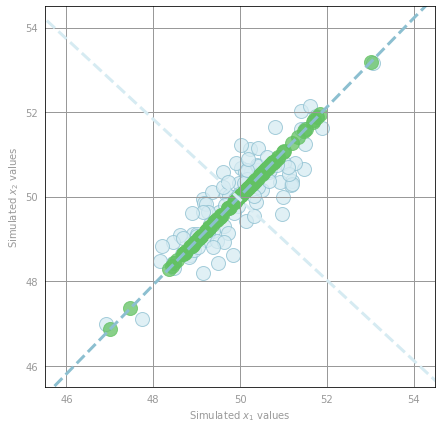

In [0]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(correlated_data, top_components_correlated, 5)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
display(fig)

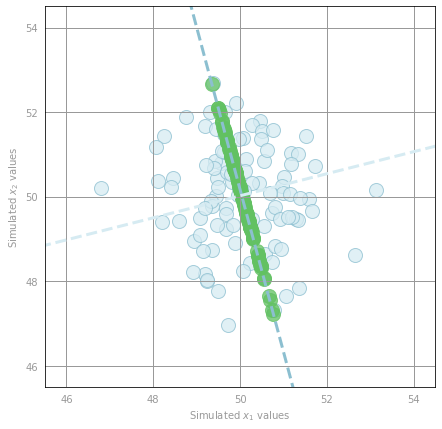

In [0]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(random_data_rdd, top_components_random, 5)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#d6ebf2', linestyle='--')
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
display(fig)

### Visualization 3: Three-dimensional data

So far we have worked with two-dimensional data. Now let's generate three-dimensional data with highly correlated features. As in Visualization 1, we'll create samples from a multivariate Gaussian distribution, which in three dimensions requires us to specify three means, three variances, and three covariances.

In the 3D graphs below, we have included the 2D plane that corresponds to the top two principal components, i.e. the plane with the smallest euclidean distance between the points and itself. Notice that the data points, despite living in three-dimensions, are found near a two-dimensional plane: the left graph shows how most points are close to the plane when it is viewed from its side, while the right graph shows that the plane covers most of the variance in the data.  Note that darker blues correspond to points with higher values for the third dimension.

/local_disk0/tmp/1614662006710-0/PythonShell.py:15: RuntimeWarning: covariance is not positive-semidefinite.
 # [ML-6297] we try to import matplotlib to preserve any unknown side-effects it might have.

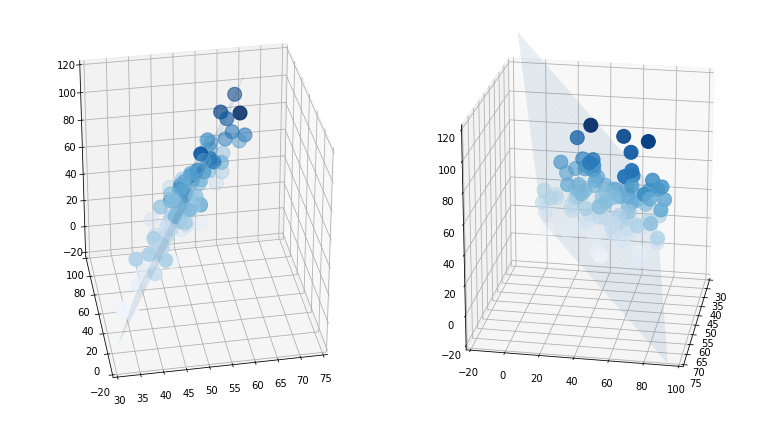

In [0]:
from mpl_toolkits.mplot3d import Axes3D

m = 100
mu = np.array([50, 50, 50])
r1_2 = 0.9
r1_3 = 0.7
r2_3 = 0.1
sigma1 = 5
sigma2 = 20
sigma3 = 20
c = np.array([[sigma1 ** 2, r1_2 * sigma1 * sigma2, r1_3 * sigma1 * sigma3],
             [r1_2 * sigma1 * sigma2, sigma2 ** 2, r2_3 * sigma2 * sigma3],
             [r1_3 * sigma1 * sigma3, r2_3 * sigma2 * sigma3, sigma3 ** 2]])
np.random.seed(142)
data_threeD = np.random.multivariate_normal(mu, c, m)

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
norm = Normalize()
cmap = get_cmap("Blues")
clrs = cmap(np.array(norm(data_threeD[:,2])))[:,0:3]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(121, projection='3d')
ax.azim=-100
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

xx, yy = np.meshgrid(np.arange(-15, 10, 1), np.arange(-50, 30, 1))
normal = np.array([0.96981815, -0.188338, -0.15485978])
z = (-normal[0] * xx - normal[1] * yy) * 1. / normal[2]
xx = xx + 50
yy = yy + 50
z = z + 50

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.10)

ax = fig.add_subplot(122, projection='3d')
ax.azim=10
ax.elev=20
#ax.dist=8
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.1)
plt.tight_layout()
display(fig)

### (2c) 3D to 2D

We will now use PCA to see if we can recover the 2-dimensional plane on which the data live. Parallelize the data, and use our PCA function from above, with \\( \scriptsize k=2 \\) components.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to apply PCA function to 3D data. You need to first parallelize the data and use the PCA function defined above with k=2 components
threeD_data = sc.parallelize(data_threeD)

components_threeD, threeD_scores, eigenvalues_threeD = pca(threeD_data, k=2)

# YOUR CODE HERE
# raise NotImplementedError()

print('components_threeD: \n{0}'.format(components_threeD))
print('\nthreeD_scores (first three): \n{0}'
       .format('\n'.join(map(str, threeD_scores.take(3)))))
print('\neigenvalues_threeD: \n{0}'.format(eigenvalues_threeD))

components_threeD: 
[[ 0.23952078 0.045635 ]
 [ 0.61699931 0.76409466]
 [ 0.74962768 -0.64348799]]

threeD_scores (first three): 
[85.25798606 -8.29694407]
[89.66337911 15.73381517]
[ 75.92616872 -20.5015709 ]

eigenvalues_threeD: 
[614.46863537 349.47737219 5.85043581]

In [0]:
# TEST 3D to 2D (2c)
assert_equal(components_threeD.shape, (3, 2), 'incorrect shape for components_threeD')
assert_true(np.allclose(np.sum(eigenvalues_threeD), 969.796443367, atol=1e-2),
                'incorrect value for eigenvalues_threeD')
assert_true(np.allclose(np.abs(np.sum(components_threeD)), 1.77238943258, atol=1e-2),
                'incorrect value for components_threeD')
assert_true(np.allclose(np.abs(np.sum(threeD_scores.take(3))), 237.782834092, atol=1e-2),
                'incorrect value for threeD_scores')


### Visualization 4: 2D representation of 3D data

See the 2D version of the data that captures most of its original structure.  Note that darker blues correspond to points with higher values for the original data's third dimension.

In [0]:
scores_threeD = np.asarray(threeD_scores.collect())

# generate layout and plot data
fig, ax = prepare_plot(np.arange(20, 150, 20), np.arange(-40, 110, 20))
ax.set_xlabel(r'New $x_1$ values'), ax.set_ylabel(r'New $x_2$ values')
ax.set_xlim(5, 150), ax.set_ylim(-45, 50)
plt.scatter(scores_threeD[:, 0], scores_threeD[:, 1], s=14 ** 2, c=clrs, edgecolors='#8cbfd0', alpha=0.75)
display(fig)

### (2d) Variance explained

Finally, let's quantify how much of the variance is being captured by PCA in each of the three synthetic datasets we've analyzed.  To do this, we'll compute the fraction of retained variance by the top principal components.  Recall that the eigenvalue corresponding to each principal component captures the variance along this direction.  If our initial data is \\(\scriptsize d\\)-dimensional, then the total variance in our data equals: \\( \scriptsize \sum_{i=1}^d \lambda_i \\), where \\(\scriptsize \lambda_i\\) is the eigenvalue corresponding to the \\(\scriptsize i\\)th principal component. Moreover, if we use PCA with some \\(\scriptsize k < d\\), then we can compute the variance retained by these principal components by adding the top \\(\scriptsize k\\) eigenvalues.  The fraction of retained variance equals the sum of the top \\(\scriptsize k\\) eigenvalues divided by the sum of all of the eigenvalues.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to compute the fraction of retained variance by the top principle components

def variance_explained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    components, scores, eigenvalues = pca(data, k)
    variances = np.sum(eigenvalues[:k])
    return (variances/np.sum(eigenvalues))
    
    # YOUR CODE HERE
#     raise NotImplementedError()

variance_random_1 = variance_explained(random_data_rdd, 1)
variance_correlated_1 = variance_explained(correlated_data, 1)
variance_random_2 = variance_explained(random_data_rdd, 2)
variance_correlated_2 = variance_explained(correlated_data, 2)
variance_threeD_2 = variance_explained(threeD_data, 2)
print ('Percentage of variance explained by the first component of random_data_rdd: {0:.1f}%'
       .format(variance_random_1 * 100))
print ('Percentage of variance explained by both components of random_data_rdd: {0:.1f}%'
       .format(variance_random_2 * 100))
print ('\nPercentage of variance explained by the first component of correlated_data: {0:.1f}%'.
       format(variance_correlated_1 * 100))
print ('Percentage of variance explained by both components of correlated_data: {0:.1f}%'
       .format(variance_correlated_2 * 100))
print ('\nPercentage of variance explained by the first two components of threeD_data: {0:.1f}%'
       .format(variance_threeD_2 * 100))

Percentage of variance explained by the first component of random_data_rdd: 58.8%
Percentage of variance explained by both components of random_data_rdd: 100.0%

Percentage of variance explained by the first component of correlated_data: 93.4%
Percentage of variance explained by both components of correlated_data: 100.0%

Percentage of variance explained by the first two components of threeD_data: 99.4%

In [0]:
# TEST Variance explained (2d)
assert_true(np.allclose(variance_random_1, 0.588017172066, atol=1e-2), 'incorrect value for variance_random_1')
assert_true(np.allclose(variance_correlated_1, 0.933608329586, atol=1e-2),
                'incorrect value for varianceCorrelated1')
assert_true(np.allclose(variance_random_2, 1.0, atol=1e-2), 'incorrect value for variance_random_2')
assert_true(np.allclose(variance_correlated_2, 1.0, atol=1e-2), 'incorrect value for variance_correlated_2')
assert_true(np.allclose(variance_threeD_2, 0.993967356912, atol=1e-2), 'incorrect value for variance_threeD_2')


## Part 3:  Parse, inspect, and preprocess neuroscience data then perform PCA

### Data introduction

A central challenge in neuroscience is understanding the organization and function of neurons, the cells responsible for processing and representing information in the brain. New technologies make it possible to monitor the responses of large populations of neurons in awake animals. In general, neurons communicate through electrical impulses that must be recorded with electrodes, which is a challenging process. As an alternative, we can genetically engineer animals so that their neurons express special proteins that fluoresce or light up when active, and then use microscopy to record neural activity as images.

Light-sheet microscopy lets us do this in a special, transparent animal, the larval zebrafish, over nearly its entire brain. The resulting data are time-varying images containing the activity of hundreds of thousands of neurons. Given the raw data, which is enormous, we want to find compact spatial and temporal patterns: Which groups of neurons are active together? What is the time course of their activity? Are those patterns specific to particular events happening during the experiment (e.g. a stimulus that we might present). PCA is a powerful technique for finding spatial and temporal patterns in these kinds of data, and that's what we'll explore here!

### (3a) Load neuroscience data

In the next sections we will use PCA to capture structure in neural datasets. Before doing the analysis, we will load and do some basic inspection of the data. The raw data are currently stored as a text file. Every line in the file contains the time series of image intensity for a single pixel in a time-varying image (i.e. a movie). The first two numbers in each line are the spatial coordinates of the pixel, and the remaining numbers are the time series. We'll use `first()` to inspect a single row, and print just the first 100 characters.

In [0]:
url = 'https://raw.githubusercontent.com/10605/data/master/hw3/neuro.txt'

from pyspark import SparkFiles

sc.addFile(url)

lines = sc.textFile("file://" + SparkFiles.get("neuro.txt"))
print(lines.first()[0:100])

# Check that everything loaded properly
assert len(lines.first()) == 1397
assert lines.count() == 46460

0 0 103 103.7 103.2 102.7 103.8 102.8 103 103.3 103.8 103.2 102.1 103.5 103.2 102.7 103.1 102.2 102.

### (3b) Parse the data

Parse the data into a key-value representation. We want each key to be a tuple of two-dimensional spatial coordinates and each value to be a NumPy array storing the associated time series. Write a function that converts a line of text into a (`tuple`, `np.ndarray`) pair. Then apply this function to each record in the RDD, and inspect the first entry of the new parsed data set. Now would be a good time to cache the data, and force a computation by calling count, to ensure the data are cached.

Note: `tuple` contains 2 integer values and the numpy array consists of float numbers.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to parse the data into (`tuple`, `np.ndarray`) format 

def parse(line):
    """Parse the raw data into a (`tuple`, `np.ndarray`) pair.

    Note:
        You should store the pixel coordinates as a tuple of two ints and the elements of the pixel intensity
        time series as an np.ndarray of floats.

    Args:
        line (str): A string representing an observation.  Elements are separated by spaces.  The
            first two elements represent the coordinates of the pixel, and the rest of the elements
            represent the pixel intensity over time.

    Returns:
        tuple of tuple, np.ndarray: A (coordinate, pixel intensity array) `tuple` where coordinate is
            a `tuple` containing two values and the pixel intensity is stored in an NumPy array
            which contains 240 values.
    """
    vector_split = line.split(' ')
    pixel_coords = (int(vector_split[0]),int(vector_split[1]))
    pixel_intensity = np.array([float(x) for x in vector_split[2:]])
    return (pixel_coords, pixel_intensity)
    
    # YOUR CODE HERE
#     raise NotImplementedError()

raw_data = lines.map(parse)
raw_data.cache()
entry = raw_data.first()
print ('Length of movie is {0} seconds'.format(len(entry[1])))
print ('Number of pixels in movie is {0:,}'.format(raw_data.count()))
print ('\nFirst entry of raw_data (with only the first five values of the NumPy array):\n({0}, {1})'
       .format(entry[0], entry[1][:5]))

Length of movie is 240 seconds
Number of pixels in movie is 46,460

First entry of raw_data (with only the first five values of the NumPy array):
((0, 0), [103. 103.7 103.2 102.7 103.8])

In [0]:
# TEST Parse the data (3b)
assert_true(isinstance(entry[0], tuple), "entry's key should be a tuple")
assert_equal(len(entry), 2, 'entry should have a key and a value')
assert_true(isinstance(entry[0][1], int), 'coordinate tuple should contain ints')
assert_equal(len(entry[0]), 2, "entry's key should have two values")
assert_true(isinstance(entry[1], np.ndarray), "entry's value should be an np.ndarray")
assert_true(isinstance(entry[1][0], np.float), 'the np.ndarray should consist of np.float values')
assert_equal(entry[0], (0, 0), 'incorrect key for entry')
assert_equal(entry[1].size, 240, 'incorrect length of entry array')
assert_true(np.allclose(np.sum(entry[1]), 24683.5), 'incorrect values in entry array')
assert_true(raw_data.is_cached, 'raw_data is not cached')


### (3c) Min and max fluorescence

Next we'll do some basic preprocessing on the data. The raw time-series data are in units of image fluorescence, and baseline fluorescence varies somewhat arbitrarily from pixel to pixel. First, compute the minimum and maximum values across all pixels.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to calculate min and max
mn = np.amin(raw_data.map(lambda x: np.amin(x[1])).collect())
mx = np.amax(raw_data.map(lambda x: np.amax(x[1])).collect())

# YOUR CODE HERE
# raise NotImplementedError()

print (mn, mx)

100.6 940.8

In [0]:
# TEST Min and max fluorescence (3c)
assert_true(np.allclose(mn, 100.6, atol=1e-2), 'incorrect value for mn')
assert_true(np.allclose(mx, 940.8, atol=1e-2), 'incorrect value for mx')


### Visualization 5: Pixel intensity

Let's now see how a random pixel varies in value over the course of the time series.  We'll visualize a pixel that exhibits a standard deviation of over 100.

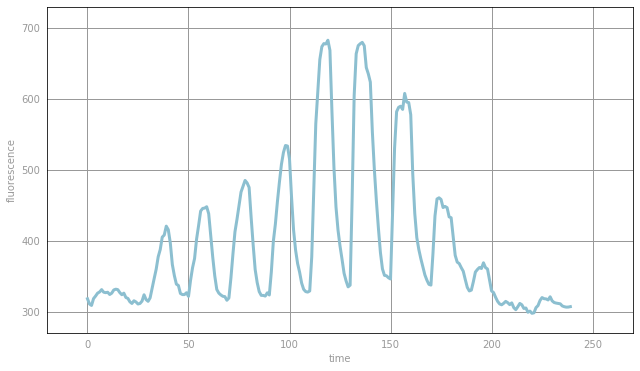

In [0]:
example = raw_data.filter(lambda x: np.std(x[1]) > 100).values().first()

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 300, 50), np.arange(300, 800, 100))
ax.set_xlabel(r'time'), ax.set_ylabel(r'fluorescence')
ax.set_xlim(-20, 270), ax.set_ylim(270, 730)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
display(fig)

### (3d) Fractional signal change

To convert from these raw fluorescence units to more intuitive units of fractional signal change, write a function that takes a time series for a particular pixel and subtracts and divides by the mean.  Then apply this function to all the pixels. Confirm that this changes the maximum and minimum values.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to standardize the array

def rescale(ts):
    """Take a np.ndarray and return the standardized array by subtracting and dividing by the mean.

    Note:
        You should first subtract the mean and then divide by the mean.

    Args:
        ts (np.ndarray): Time series data (`np.float`) representing pixel intensity.

    Returns:
        np.ndarray: The times series adjusted by subtracting the mean and dividing by the mean.
    """
    return (ts-ts.mean())/ts.mean()
    # YOUR CODE HERE
#     raise NotImplementedError()

scaled_data = raw_data.mapValues(lambda v: rescale(v))
mn_scaled = scaled_data.map(lambda x: x[1]).map(lambda v: min(v)).min()
mx_scaled = scaled_data.map(lambda x: x[1]).map(lambda v: max(v)).max()
print(mn_scaled, mx_scaled)

-0.2715128801250301 0.9054487643483778

In [0]:
# TEST Fractional signal change (3d)
assert_true(isinstance(scaled_data.first()[1], np.ndarray), 'incorrect type returned by rescale')
assert_true(np.allclose(mn_scaled, -0.27151288, atol=1e-2), 'incorrect value for mn_scaled')
assert_true(np.allclose(mx_scaled, 0.90544876, atol=1e-2), 'incorrect value for mx_scaled')


### Visualization 6: Normalized data

Now that we've normalized our data, let's once again see how a random pixel varies in value over the course of the time series.  We'll visualize a pixel that exhibits a standard deviation of over 0.1.  Note the change in scale on the y-axis compared to the previous visualization.

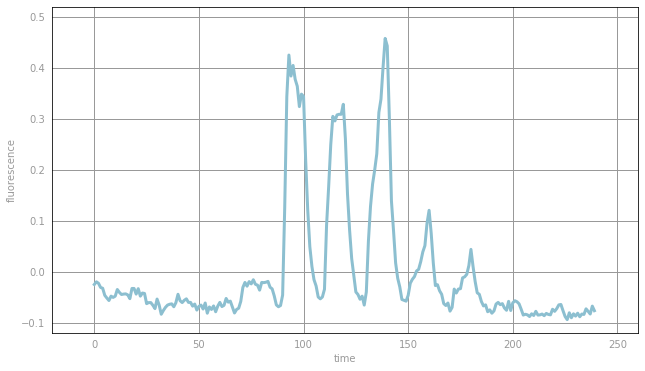

In [0]:
example = scaled_data.filter(lambda x: np.std(x[1]) > 0.1).values().first()

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 300, 50), np.arange(-.1, .6, .1))
ax.set_xlabel(r'time'), ax.set_ylabel(r'fluorescence')
ax.set_xlim(-20, 260), ax.set_ylim(-.12, .52)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
display(fig)

### (3e) PCA on the scaled data

We now have a preprocessed dataset with \\(\scriptsize n = 46460\\) pixels and \\(\scriptsize d = 240\\) seconds of time series data for each pixel.  We can interpret the pixels as our observations and each pixel value in the time series as a feature.  We would like to find patterns in brain activity during this time series, and we expect to find correlations over time.  We can thus use PCA to find a more compact representation of our data and allow us to visualize it.

Use the `pca` function from Part (2a) to perform PCA on the preprocessed neuroscience data with \\(\scriptsize k = 3\\), resulting in a new low-dimensional 46460 by 3 dataset.  The `pca` function takes an RDD of arrays, but `scaled_data` is an RDD of key-value pairs, so you'll need to extract the values.

In [0]:
# # TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to run pca using scaled_data

components_scaled, scaled_scores, eigenvalues_scaled = pca(scaled_data.values(),k=3)

# YOUR CODE HERE
# raise NotImplementedError()

print ('components_scaled: (first five) \n{0}'.format(components_scaled[:5, :]))
print ('\nscaled_scores (first three): \n{0}'
       .format('\n'.join(map(str, scaled_scores.take(3)))))
print ('\neigenvalues_scaled: (first five) \n{0}'.format(eigenvalues_scaled[:5]))

components_scaled: (first five) 
[[-0.02085344 0.07438641 -0.10282788]
 [-0.02906087 0.05946577 -0.0916922 ]
 [-0.03785299 0.04426045 -0.06664774]
 [-0.04698154 0.02839291 -0.03877678]
 [-0.04838719 0.01862108 -0.02519698]]

scaled_scores (first three): 
[-0.00392635 0.00315696 0.00027639]
[ 0.00603553 0.01250631 -0.00221771]
[ 0.00230624 0.01268276 -0.00226939]

eigenvalues_scaled: (first five) 
[0.10891779 0.05496768 0.02565018 0.00935326 0.0080986 ]

In [0]:
# TEST PCA on the scaled data (3e)
assert_equal(components_scaled.shape, (240, 3), 'incorrect shape for components_scaled')
assert_true(np.allclose(np.abs(np.sum(components_scaled[:5, :])), 0.283150995232, atol=1e-2),
                'incorrect value for components_scaled')
assert_true(np.allclose(np.abs(np.sum(scaled_scores.take(3))), 0.0285507449251, atol=1e-2),
                'incorrect value for scaled_scores')
assert_true(np.allclose(np.sum(eigenvalues_scaled[:5]), 0.206987501564, atol=1e-2),
                'incorrect value for eigenvalues_scaled')


### Visualization 7: Top two components as images

Now, we'll view the scores for the top two components as images.  Note that we reshape the vectors by the dimensions of the original image, 230 x 202.
These graphs map the values for the single component to a grayscale image.  This provides us with a visual representation which we can use to see the overall structure of the zebrafish brain and to identify where high and low values occur.  However, using this representation, there is a substantial amount of useful information that is difficult to interpret.  In the next visualization, we'll see how we can improve interpretability by combining the two principal components into a single image using a color mapping.

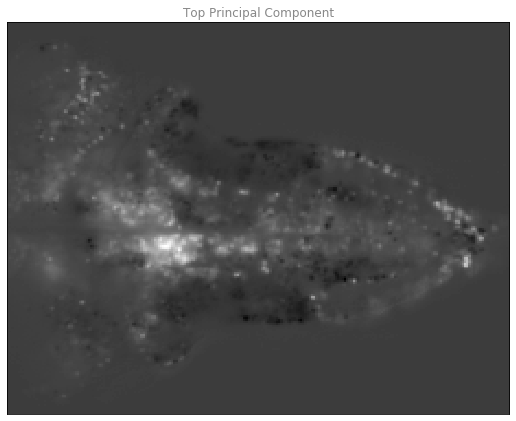

In [0]:
import matplotlib.cm as cm

scores_scaled = np.vstack(scaled_scores.collect())
image_one_scaled = scores_scaled[:, 0].reshape(230, 202).T

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
ax.set_title('Top Principal Component', color='#888888')
image = plt.imshow(image_one_scaled, interpolation='nearest', aspect='auto', cmap=cm.gray)
display(fig)

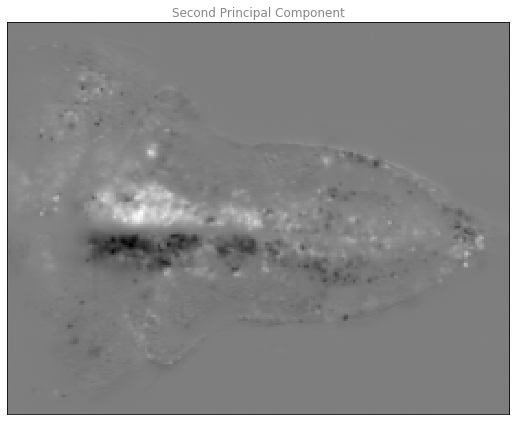

In [0]:
image_two_scaled = scores_scaled[:, 1].reshape(230, 202).T

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
ax.set_title('Second Principal Component', color='#888888')
image = plt.imshow(image_two_scaled, interpolation='nearest', aspect='auto', cmap=cm.gray)
display(fig)


### Visualization 8: Top two components as one image

When we perform PCA and color neurons based on their location in the low-dimensional space, we can interpret areas with similar colors as exhibiting similar responses (at least in terms of the simple representation we recover with PCA). Below, the first graph shows how low-dimensional representations, which correspond to the first two principal components, are mapped to colors. The second graph shows the result of this color mapping using the zebrafish neural data.

The second graph clearly exhibits patterns of neural similarity throughout different regions of the brain.  However, when performing PCA on the full dataset, there are multiple reasons why neurons might have similar responses. The neurons might respond similarly to different stimulus directions, their responses might have  similar temporal dynamics, or their response similarity could be influenced by both temporal and stimulus-specific factors. However, with our initial PCA analysis, we cannot pin down the underlying factors, and hence it is hard to interpret what "similarity" really means.

Optional Details: Note that we use [polar coordinates](https://en.wikipedia.org/wiki/Polar_coordinate_system) to map our low-dimensional points to colors.  Using polar coordinates provides us with an angle \\( (\phi) \\) and magnitude \\( (\rho) \\).  We then use the well-known polar color space, [hue-saturation-value](https://en.wikipedia.org/wiki/HSL_and_HSV) (HSV), and map the angle to hue and the magnitude to value (brightness).  This maps low magnitude points to black while allowing larger magnitude points to be differentiated by their angle. Additionally, the function `polarTransform` that maps low-dimensional representations to colors has an input parameter called `scale`, which we set  to 2.0, and you can try lower values for the two graphs to see more nuanced mappings -- values near 1.0 are particularly interesting.

In [0]:
# Adapted from python-thunder's Colorize.transform where cmap='polar'.
# Checkout the library at: https://github.com/thunder-project/thunder and
# http://thunder-project.org/

def polar_transform(scale, img):
    """Convert points from cartesian to polar coordinates and map to colors."""
    from matplotlib.colors import hsv_to_rgb

    img = np.asarray(img)
    dims = img.shape

    phi = ((np.arctan2(-img[0], -img[1]) + np.pi/2) % (np.pi*2)) / (2 * np.pi)
    rho = np.sqrt(img[0]**2 + img[1]**2)
    saturation = np.ones((dims[1], dims[2]))

    out = hsv_to_rgb(np.dstack((phi, saturation, scale * rho)))

    return np.clip(out * scale, 0, 1)

In [0]:
# Show the polar mapping from principal component coordinates to colors.
x1_abs_max = np.max(np.abs(image_one_scaled))
x2_abs_max = np.max(np.abs(image_two_scaled))

num_of_pixels = 300
x1_vals = np.arange(-x1_abs_max, x1_abs_max, (2 * x1_abs_max) / num_of_pixels)
x2_vals = np.arange(x2_abs_max, -x2_abs_max, -(2 * x2_abs_max) / num_of_pixels)
x2_vals.shape = (num_of_pixels, 1)

x1_data = np.tile(x1_vals, (num_of_pixels, 1))
x2_data = np.tile(x2_vals, (1, num_of_pixels))

# Try changing the first parameter to lower values
polar_map = polar_transform(2.0, [x1_data, x2_data])

grid_range = np.arange(0, num_of_pixels + 25, 25)
fig, ax = prepare_plot(grid_range, grid_range, figsize=(9.0, 7.2), hide_labels=True)
image = plt.imshow(polar_map, interpolation='nearest', aspect='auto')
ax.set_xlabel('Principal component one'), ax.set_ylabel('Principal component two')
grid_marks = (2 * grid_range / float(num_of_pixels) - 1.0)
x1_marks = x1_abs_max * grid_marks
x2_marks = -x2_abs_max * grid_marks
ax.get_xaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x1_marks))
ax.get_yaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x2_marks))
display(fig)

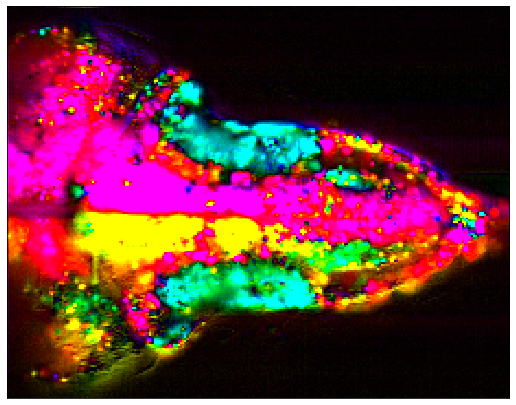

In [0]:
# Use the same transformation on the image data
# Try changing the first parameter to lower values
brainmap = polar_transform(2.0, [image_one_scaled, image_two_scaled])

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
display(fig)

## Part 4: Feature-based aggregation and PCA

### (4a) Aggregation using arrays

In the analysis in Part 3, we performed PCA on the full time series data, trying to find global patterns across all 240 seconds of the time series. However, our analysis doesn't use the fact that different events happened during those 240 seconds. Specifically, during those 240 seconds, the zebrafish was presented with 12 different direction-specific visual patterns, with each one lasting for 20 seconds, for a total of 12 x 20 = 240 features. Stronger patterns are likely to emerge if we incorporate knowledge of our experimental setup into our analysis.  As we'll see, we can isolate the impact of temporal response or direction-specific impact by appropriately aggregating our features.

In order to aggregate the features we will use basic ideas from matrix multiplication.  First, note that if we use `np.dot` with a two-dimensional array, then NumPy performs the equivalent matrix-multiply calculation.  For example, `np.array([[1, 2, 3], [4, 5, 6]]).dot(np.array([2, 0, 1]))` produces `np.array([5, 14])`.

\\[\begin{bmatrix} 1 & 2 & 3 \\\ 4 & 5 & 6 \end{bmatrix} \begin{bmatrix} 2 \\\ 0 \\\ 1 \end{bmatrix} = \begin{bmatrix} 5 \\\ 14 \end{bmatrix} \\]

By setting up our multi-dimensional array properly we can multiply it by a vector to perform certain aggregation operations.  For example, imagine we had a 3 dimensional vector, \\( \scriptsize \begin{bmatrix} 1 & 2 & 3 \end{bmatrix}^\top \\)  and we wanted to create a 2 dimensional vector containing the sum of its first and last elements as one value and three times its second value as another value, i.e., \\( \scriptsize \begin{bmatrix} 4 & 6 \end{bmatrix}^\top \\). We can generate this result via matrix multiplication as follows: `np.array([[1, 0, 1], [0, 3, 0]]).dot(np.array([1, 2, 3])` which produces `np.array([4, 6]`.

\\[\begin{bmatrix} 1 & 0 & 1 \\\ 0 & 3 & 0 \end{bmatrix} \begin{bmatrix} 1 \\\ 2 \\\ 3 \end{bmatrix} = \begin{bmatrix} 4 \\\ 6 \end{bmatrix} \\]

For this exercise, you'll create several arrays that perform different types of aggregation.  The aggregation is specified in the comments before each array.  You should fill in the array values by hand.  We'll automate array creation in the next two exercises.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to create arrays for different types of arregation
vector = np.array([0., 1., 2., 3., 4., 5.])

# # Create a multi-dimensional array that when multiplied (using .dot) against vector, results in
# # a two element array where the first element is the sum of the 0, 2, and 4 indexed elements of
# # vector and the second element is the sum of the 1, 3, and 5 indexed elements of vector.
# # This should be a 2 row by 6 column array

sum_every_other = np.array([[1,0,1,0,1,0],
                            [0,1,0,1,0,1]])

# YOUR CODE HERE
# raise NotImplementedError()

# # Create a multi-dimensional array that when multiplied (using .dot) against vector, results in a
# # three element array where the first element is the sum of the 0 and 3 indexed elements of vector,
# # the second element is the sum of the 1 and 4 indexed elements of vector, and the third element is
# # the sum of the 2 and 5 indexed elements of vector.
# # This should be a 3 row by 6 column array

sum_every_third = np.array([[1,0,0,1,0,0],
                            [0,1,0,0,1,0],
                            [0,0,1,0,0,1]])

# YOUR CODE HERE
# raise NotImplementedError()

# # Create a multi-dimensional array that can be used to sum the first three elements of vector and
# # the last three elements of vector, which returns a two element array with those values when dotted
# # with vector.
# # This should be a 2 row by 6 column array

sum_by_three = np.array([[1,1,1,0,0,0],
                         [0,0,0,1,1,1]])

# YOUR CODE HERE
# raise NotImplementedError()

# # Create a multi-dimensional array that that sums the first two elements, second two elements, and
# # last two elements of vector, which returns a three element array with those values when dotted
# # with vector.
# # This should be a 3 row by 6 column array
sum_by_two = np.array([[1,1,0,0,0,0],
                       [0,0,1,1,0,0],
                       [0,0,0,0,1,1]])

# YOUR CODE HERE
# raise NotImplementedError()

print ('sum_every_other.dot(vector):\t{0}'.format(sum_every_other.dot(vector)))
print ('sum_every_third.dot(vector):\t{0}'.format(sum_every_third.dot(vector)))

print ('\nsum_by_three.dot(vector):\t{0}'.format(sum_by_three.dot(vector)))
print ('sum_by_two.dot(vector): \t{0}'.format(sum_by_two.dot(vector)))

sum_every_other.dot(vector):	[6. 9.]
sum_every_third.dot(vector):	[3. 5. 7.]

sum_by_three.dot(vector):	[ 3. 12.]
sum_by_two.dot(vector): [1. 5. 9.]

In [0]:
# TEST Aggregation using arrays (4a)
assert_equal(sum_every_other.shape, (2, 6), 'incorrect shape for sum_every_other')
assert_equal(sum_every_third.shape, (3, 6), 'incorrect shape for sum_every_third')
assert_true(np.allclose(sum_every_other.dot(vector), [6, 9]), 'incorrect value for sum_every_other')
assert_true(np.allclose(sum_every_third.dot(vector), [3, 5, 7]),
                'incorrect value for sum_every_third')
assert_equal(sum_by_three.shape, (2, 6), 'incorrect shape for sum_by_three')
assert_equal(sum_by_two.shape, (3, 6), 'incorrect shape for sum_by_two')
assert_true(np.allclose(sum_by_three.dot(vector), [3, 12]), 'incorrect value for sum_by_three')
assert_true(np.allclose(sum_by_two.dot(vector), [1, 5, 9]), 'incorrect value for sum_by_two')


### (4b) Recreate with `np.tile` and `np.eye`
[np.tile](http://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html) is useful for repeating arrays in one or more dimensions.  For example, `np.tile(np.array([[1, 2], [3, 4]]), 2)` produces `np.array([[1, 2, 1, 2], [3, 4, 3, 4]]))`.

 \\[ np.tile( \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} , 2) \to \begin{bmatrix} 1 & 2 & 1& 2 \\\ 3 & 4 & 3 & 4 \end{bmatrix} \\]

Recall that [np.eye](http://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html) can be used to create an identity array \\( (\mathbf{I_n}) \\).  For example, `np.eye(3)` produces `np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])`.

\\[ np.eye( 3 ) \to \begin{bmatrix} 1 & 0 & 0 \\\ 0 & 1 & 0 \\\ 0 & 0 & 1 \end{bmatrix} \\]

In this exercise, recreate `sum_every_other` and `sum_every_third` using `np.tile` and `np.eye`.

In [0]:
# Reference for what to recreate
print ('sum_every_other: \n{0}'.format(sum_every_other))
print ('\nsum_every_third: \n{0}'.format(sum_every_third))

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to use np.tile and np.eye to recreate the arrays

sum_every_other_tile = np.tile(np.eye(2), 3)
sum_every_third_tile = np.tile(np.eye(3), 2)

# YOUR CODE HERE
# raise NotImplementedError()

print (sum_every_other_tile)
print ('sum_every_other_tile.dot(vector): {0}'.format(sum_every_other_tile.dot(vector)))
print ('\n', sum_every_third_tile)
print ('sum_every_third_tile.dot(vector): {0}'.format(sum_every_third_tile.dot(vector)))

[[1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1.]]
sum_every_other_tile.dot(vector): [6. 9.]

 [[1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]]
sum_every_third_tile.dot(vector): [3. 5. 7.]

In [0]:
# TEST Recreate with `np.tile` and `np.eye` (4b)
assert_equal(sum_every_other_tile.shape, (2, 6), 'incorrect shape for sum_every_other_tile')
assert_equal(sum_every_third_tile.shape, (3, 6), 'incorrect shape for sum_every_third_tile')
assert_true(np.allclose(sum_every_other_tile.dot(vector), [6, 9]),
                'incorrect value for sum_every_other_tile')
assert_true(np.allclose(sum_every_third_tile.dot(vector), [3, 5, 7]),
                'incorrect value for sum_every_third_tile')


### (4c) Recreate with `np.kron`
The Kronecker product is the generalization of outer products involving matrices, and we've included some examples below to illustrate the idea.  Please refer to the [Wikipedia page](https://en.wikipedia.org/wiki/Kronecker_product) for a detailed definition.  We can use [np.kron](http://docs.scipy.org/doc/numpy/reference/generated/numpy.kron.html) to compute Kronecker products and recreate the `sum_by` arrays.  Note that \\( \otimes \\) indicates a Kronecker product.

\\[ \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} \otimes \begin{bmatrix} 1 & 2 \end{bmatrix}  = \begin{bmatrix} 1 \cdot 1 & 1 \cdot 2 & 2 \cdot 1 & 2 \cdot 2 \\\ 3 \cdot 1 & 3 \cdot 2 & 4 \cdot 1 & 4 \cdot 2 \end{bmatrix} = \begin{bmatrix} 1 & 2 & 2 & 4 \\\ 3 & 6 & 4 & 8 \end{bmatrix}  \\]

We can see how the Kronecker product continues to expand if there are multiple rows in the second array.

\\[ \begin{bmatrix} 1 & 2 \\\ 3 & 4 \end{bmatrix} \otimes \begin{bmatrix} 5 & 6 \\\ 7 & 8 \end{bmatrix} = \begin{bmatrix} 1 \cdot \begin{bmatrix} 5 & 6 \\\ 7 & 8 \end{bmatrix} & 2 \cdot \begin{bmatrix} 5 & 6 \\\ 7 & 8 \end{bmatrix} \\\ \\\ 3 \cdot \begin{bmatrix} 5 & 6 \\\ 7 & 8 \end{bmatrix} & 4 \cdot \begin{bmatrix} 5 & 6 \\\ 7 & 8 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 5 & 6 & 10 & 12 \\\ 7 & 8 & 14 & 16 \\\ 15 & 18 & 20 & 24 \\\ 21 & 24 & 28 & 32 \end{bmatrix} \\]

For this exercise, you'll recreate the `sum_by_three` and `sum_by_two` arrays using `np.kron`, `np.eye`, and `np.ones`.  Note that `np.ones` creates an array of all ones.

In [0]:
# Reference for what to recreate
print ('sum_by_three: \n{0}'.format(sum_by_three))
print ('\nsum_by_two: \n{0}'.format(sum_by_two))

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to use np.kron, np.eye, and np.ones to recreate the arrays

sum_by_three_kron = np.kron(np.eye(2), np.ones(3))
sum_by_two_kron = np.kron(np.eye(3), np.ones(2))

# YOUR CODE HERE
# raise NotImplementedError()

print (sum_by_three_kron)
print ('sum_by_three_kron.dot(vector): {0}'.format(sum_by_three_kron.dot(vector)))
print ('\n', sum_by_two_kron)
print ('sum_by_two_kron.dot(vector): {0}'.format(sum_by_two_kron.dot(vector)))

[[1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1.]]
sum_by_three_kron.dot(vector): [ 3. 12.]

 [[1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]
sum_by_two_kron.dot(vector): [1. 5. 9.]

In [0]:
# TEST Recreate with `np.kron` (4c)
assert_equal(sum_by_three_kron.shape, (2, 6), 'incorrect shape for sum_by_three_kron')
assert_equal(sum_by_two_kron.shape, (3, 6), 'incorrect shape for sum_by_two_kron')
assert_true(np.allclose(sum_by_three_kron.dot(vector), [3, 12]),
                'incorrect value for sum_by_three_kron')
assert_true(np.allclose(sum_by_two_kron.dot(vector), [1, 5, 9]),
                'incorrect value for sum_by_two_kron')


### (4d) Aggregate by time

As we discussed in Part (4a), we would like to incorporate knowledge of our experimental setup into our analysis. To do this, we'll first study the temporal aspects of neural response, by aggregating our features by time. In other words, we want to see how different pixels (and the underlying neurons captured in these pixels) react in each of the 20 seconds after a new visual pattern is displayed, regardless of what the pattern is.  Hence, instead of working with the 240 features individually, we'll aggregate the original features into 20 new features, where the first new feature captures the pixel response one second after a visual pattern appears, the second new feature is the response after two seconds, and so on.

We can perform this aggregation using a map operation. First, build a multi-dimensional array \\( \scriptsize \mathbf{T} \\) that, when dotted with a 240-component vector, sums every 20-th component of this vector and returns a 20-component vector. Note that this exercise is similar to (4b).  Once you have created your multi-dimensional array \\( \scriptsize \mathbf{T} \\), use a `map` operation with that array and each time series to generate a transformed dataset. We'll cache and count the output, as we'll be using it again.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to create a multi-dimensional array to perform the aggregation
# # Create a multi-dimensional array to perform the aggregation
T = np.tile(np.eye(20), 12)

# Transform scaled_data using T.  Make sure to retain the keys.
time_data = scaled_data.mapValues(lambda x: np.dot(T,x))

# YOUR CODE HERE
# raise NotImplementedError()

time_data.cache()
print (time_data.count())
print (time_data.first())

46460
((0, 0), array([ 0.00802155, 0.00607693, -0.0075354 , 0.00121539, 0.02163388,
 0.00121539, -0.03087082, 0.00510462, 0.01191079, 0.02455081,
 -0.0182308 , 0.00802155, -0.00948002, -0.00948002, 0.02163388,
 -0.02212004, 0.00704924, 0.00121539, -0.01142464, -0.00850771]))

In [0]:
# TEST Aggregate by time (4d)
assert_equal(T.shape, (20, 240), 'incorrect shape for T')
time_data_first = time_data.values().first()
time_data_fifth = time_data.values().take(5)[4]
assert_equal(time_data.count(), 46460, 'incorrect length of time_data')
assert_equal(time_data_first.size, 20, 'incorrect value length of time_data')
assert_equal(time_data.keys().first(), (0, 0), 'incorrect keys in time_data')
assert_true(np.allclose(time_data_first[:2], [0.00802155, 0.00607693], atol=1e-2),
                'incorrect values in time_data')
assert_true(np.allclose(time_data_fifth[-2:], [-0.00636676, -0.0179427], atol=1e-2),
                'incorrect values in time_data')


### (4e) Obtain a compact representation

We now have a time-aggregated dataset with \\(\scriptsize n = 46460\\) pixels and \\(\scriptsize d = 20\\) aggregated time features, and we want to use PCA to find a more compact representation.  Use the `pca` function from Part (2a) to perform PCA on the this data with \\(\scriptsize k = 3\\), resulting in a new low-dimensional 46,460 by 3 dataset. As before, you'll need to extract the values from `time_data` since it is an RDD of key-value pairs.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to extract a compact representation from time_data using pca function from Part (2a)

components_time, time_scores, eigenvalues_time = pca(time_data.values(),k=3)

# YOUR CODE HERE
# raise NotImplementedError()

print ('components_time: (first five) \n{0}'.format(components_time[:5, :]))
print ('\ntime_scores (first three): \n{0}'
       .format('\n'.join(map(str, time_scores.take(3)))))
print ('\neigenvalues_time: (first five) \n{0}'.format(eigenvalues_time[:5]))

components_time: (first five) 
[[ 0.27392702 -0.16152431 0.01388556]
 [ 0.09941893 -0.31968127 -0.34738824]
 [-0.03376505 -0.32933108 -0.35606954]
 [-0.12092744 -0.2845482 -0.27232364]
 [-0.18219248 -0.22998061 -0.12248985]]

time_scores (first three): 
[-0.00720617 -0.00292979 -0.00223645]
[ 0.02353076 -0.00197457 0.00362094]
[ 0.01310623 0.00123069 -0.00582974]

eigenvalues_time: (first five) 
[0.77528991 0.05038881 0.01173423 0.0059711 0.00138073]

In [0]:
# TEST Obtain a compact representation (4e)
assert_equal(components_time.shape, (20, 3), 'incorrect shape for components_time')
assert_true(np.allclose(np.abs(np.sum(components_time[:5, :])), 2.37299020, atol=1e-2),
                'incorrect value for components_time')
assert_true(np.allclose(np.abs(np.sum(time_scores.take(3))), 0.0213119114, atol=1e-2),
                'incorrect value for time_scores')
assert_true(np.allclose(np.sum(eigenvalues_time[:5]), 0.844764792, atol=1e-2),
                'incorrect value for eigenvalues_time')


### Visualization 9: Top two components by time

Let's view the scores from the first two principal components as a composite image. When we preprocess by aggregating by time and then perform PCA, we are only looking at variability related to temporal dynamics. As a result, if neurons appear similar -- have similar colors -- in the resulting image, it means that their responses vary similarly over time, regardless of how they might be encoding direction. In the image below, we can define the midline as the horizontal line across the middle of the brain.  We see clear patterns of neural activity in different parts of the brain, and crucially note that the regions on either side of the midline are similar, which suggests that temporal dynamics do not differ across the two sides of the brain.

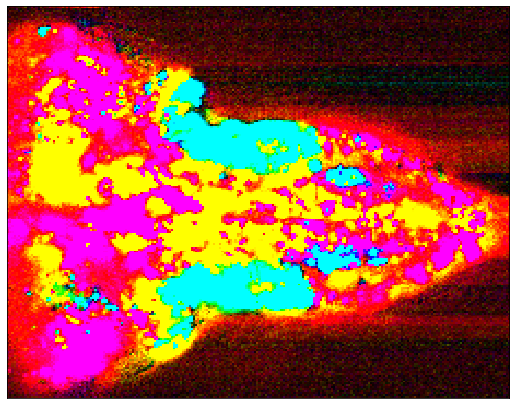

In [0]:
scores_time = np.vstack(time_scores.collect())
image_one_time = scores_time[:, 0].reshape(230, 202).T
image_two_time = scores_time[:, 1].reshape(230, 202).T
brainmap = polar_transform(3, [image_one_time, image_two_time])

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
display(fig)

### (4f) Aggregate by direction

Next, let's perform a second type of feature aggregation so that we can study the direction-specific aspects of neural response, by aggregating our features by direction. In other words, we want to see how different pixels (and the underlying neurons captured in these pixels) react when the zebrafish is presented with 12 direction-specific patterns, ignoring the temporal aspect of the reaction.  Hence, instead of working with the 240 features individually, we'll aggregate the original features into 12 new features, where the first new feature captures the average pixel response to the first direction-specific visual pattern, the second new feature is the response to the second direction-specific visual pattern, and so on.

As in Part (4c), we'll design a multi-dimensional array \\( \scriptsize \mathbf{D} \\) that, when multiplied by a 240-dimensional vector, sums the first 20 components, then the second 20 components, and so on. Note that this is similar to exercise (4c).  First create \\( \scriptsize \mathbf{D} \\), then use a `map` operation with that array and each time series to generate a transformed dataset. We'll cache and count the output, as we'll be using it again.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to create a multi-dimensional array to perform the aggregation
D = np.kron(np.eye(12), np.ones(20))

# # Transform scaled_data using D.  Make sure to retain the keys.
direction_data = scaled_data.mapValues(lambda x: np.dot(D,x))

# YOUR CODE HERE
# raise NotImplementedError()

direction_data.cache()
print (direction_data.count())
print (direction_data.first())

46460
((0, 0), array([ 0.03346365, 0.03638058, -0.02195799, -0.02487492, 0.00721129,
 0.00332206, -0.02098568, 0.00915591, -0.00542873, -0.01029027,
 0.0081836 , -0.01417951]))

In [0]:
# TEST Aggregate by direction (4f)
assert_equal(D.shape, (12, 240), 'incorrect shape for D')
direction_data_first = direction_data.values().first()
direction_data_fifth = direction_data.values().take(5)[4]
assert_equal(direction_data.count(), 46460, 'incorrect length of direction_data')
assert_equal(direction_data_first.size, 12, 'incorrect value length of direction_data')
assert_equal(direction_data.keys().first(), (0, 0), 'incorrect keys in direction_data')
assert_true(np.allclose(direction_data_first[:2], [0.03346365, 0.03638058], atol=1e-2),
                'incorrect values in direction_data')
assert_true(np.allclose(direction_data_fifth[:2], [0.01479147, -0.02090099], atol=1e-2),
                'incorrect values in direction_data')


### (4g) Compact representation of direction data

We now have a direction-aggregated dataset with \\(\scriptsize n = 46460\\) pixels and \\(\scriptsize d = 12\\) aggregated direction features, and we want to use PCA to find a more compact representation.  Use the `pca` function from Part (2a) to perform PCA on the this data with \\(\scriptsize k = 3\\), resulting in a new low-dimensional 46460 by 3 dataset. As before, you'll need to extract the values from `direction_data` since it is an RDD of key-value pairs.

In [0]:
# TODO: Uncomment the lines below and replace <FILL_IN> with appropriate code to get compact representation of direction data using pca function
components_direction, direction_scores, eigenvalues_direction = pca(direction_data.values(),k=3)

# YOUR CODE HERE
# raise NotImplementedError()

print ('components_direction: (first five) \n{0}'.format(components_direction[:5, :]))
print ('\ndirection_scores (first three): \n{0}'
       .format('\n'.join(map(str, direction_scores.take(3)))))
print ('\neigenvalues_direction: (first five) \n{0}'.format(eigenvalues_direction[:5]))

components_direction: (first five) 
[[-0.25952179 0.16201941 0.24947433]
 [-0.31369506 -0.09185175 0.29464223]
 [-0.21716693 -0.35944645 0.35296454]
 [-0.11517273 -0.37356905 0.07169062]
 [ 0.02996577 -0.36272623 -0.14783897]]

direction_scores (first three): 
[-0.01622513 0.01322998 0.01322204]
[ 0.00999482 0.0652367 -0.04524758]
[0.004646 0.05751097 0.00756383]

eigenvalues_direction: (first five) 
[0.96411048 0.77613553 0.12762987 0.09775924 0.04333691]

In [0]:
# TEST Compact representation of direction data (4g)
assert_equal(components_direction.shape, (12, 3), 'incorrect shape for components_direction')
assert_true(np.allclose(np.abs(np.sum(components_direction[:5, :])), 1.080232069, atol=1e-2),
                'incorrect value for components_direction')
assert_true(np.allclose(np.abs(np.sum(direction_scores.take(3))), 0.10993162084, atol=1e-2),
                'incorrect value for direction_scores')
assert_true(np.allclose(np.sum(eigenvalues_direction[:5]), 2.0089720377, atol=1e-2),
                'incorrect value for eigenvalues_direction')


### Visualization 10: Top two components by direction

Again, let's view the scores from the first two principal components as a composite image.  When we preprocess by averaging across time (group by direction), and then perform PCA, we are only looking at variability related to stimulus direction. As a result, if neurons appear similar -- have similar colors -- in the image, it means that their responses vary similarly across directions, regardless of how they evolve over time. In the image below, we see a different pattern of similarity across regions of the brain.  Moreover, regions on either side of the midline are colored differently, which suggests that we are looking at a property, direction selectivity, that has a different representation across the two sides of the brain.

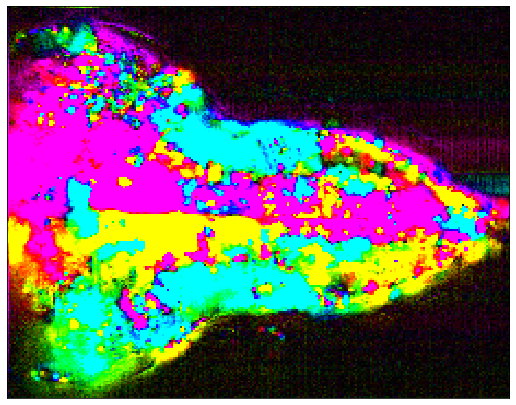

In [0]:
scores_direction = np.vstack(direction_scores.collect())
image_one_direction = scores_direction[:, 0].reshape(230, 202).T
image_two_direction = scores_direction[:, 1].reshape(230, 202).T
brainmap = polar_transform(2, [image_one_direction, image_two_direction])
# with thunder: Colorize(cmap='polar', scale=2).transform([image_one_direction, image_two_direction])

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
image = plt.imshow(brainmap, interpolation='nearest', aspect='auto')
display(fig)